## Practical-3
## Name:Satwik Shirpurwar
## Roll No:52
## Batch:A3


In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

 Code for Creating Layers

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, activation='relu'):
        """
        Initialize a neural network layer

        Args:
            input_size (int): Number of input features
            output_size (int): Number of neurons in the layer
            activation (str): Activation function to use ('relu', 'sigmoid', or 'softmax')
        """
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

    def forward(self, inputs):
        """Forward pass through the layer"""
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias

        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.output = 1 / (1 + np.exp(-self.z))
        elif self.activation == 'softmax':
            # Calculate softmax
            exp_scores = np.exp(self.z)
            self.output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # added calculation for softmax

        return self.output

    def backward(self, output_gradient, learning_rate):
        """Backward pass through the layer"""
        if self.activation == 'relu':
            activation_gradient = np.where(self.z > 0, 1, 0)
        elif self.activation == 'sigmoid':
            activation_gradient = self.output * (1 - self.output)
        elif self.activation == 'softmax':  # Add case for softmax
            activation_gradient = output_gradient # added gradient for softmax

        activation_gradient *= output_gradient.astype(np.int32)

        # Calculate gradients
        weights_gradient = np.dot(self.inputs.T, activation_gradient)
        input_gradient = np.dot(activation_gradient, self.weights.T)

        # Update parameters
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.sum(activation_gradient, axis=0, keepdims=True)

        return input_gradient

In [ ]:
class FeedForwardNN:
    def __init__(self):
        """Initialize the neural network"""
        self.layers = []

    def add_layer(self, input_size, output_size, activation='relu'):
        """Add a layer to the network"""
        layer = Layer(input_size, output_size, activation)
        self.layers.append(layer)

    def forward(self, X):
        """Forward pass through the entire network"""
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, loss_gradient, learning_rate):
        """Backward pass through the entire network"""
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def train(self, X, y, epochs, learning_rate=0.01, batch_size=32):
        """
        Train the neural network

        Args:
            X: Input features
            y: Target values
            epochs: Number of training epochs
            learning_rate: Learning rate for gradient descent
            batch_size: Size of mini-batches
        """
        for epoch in range(epochs):
            total_loss = 0

            # Mini-batch training
            for i in range(0, len(X), batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y[i:i + batch_size]

                # Forward pass
                predictions = self.forward(batch_X)

                # Calculate loss (MSE)
                loss = np.mean((predictions.astype(np.int32) - batch_y.astype(np.int32)) ** 2)
                total_loss += loss

                # Calculate loss gradient
                loss_gradient = 2 * (predictions.astype(np.int32) - batch_y.astype(np.int32)) / batch_size

                # Backward pass
                self.backward(loss_gradient, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(X)}")

In [ ]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    X = np.random.randn(1000, 3)  # 1000 samples, 3 features
    y = np.sum(X, axis=1, keepdims=True) > 0  # Binary classification

    # Create and configure the network
    model = FeedForwardNN()
    model.add_layer(input_size=3, output_size=4, activation='relu')
    model.add_layer(input_size=4, output_size=4, activation='relu')
    model.add_layer(input_size=4, output_size=1, activation='sigmoid')

    # Train the network
    model.train(X, y, epochs=1000, learning_rate=0.01, batch_size=32)

Epoch 0, Loss: 0.0156875
Epoch 100, Loss: 0.0156875
Epoch 200, Loss: 0.0156875
Epoch 300, Loss: 0.0156875
Epoch 400, Loss: 0.0156875
Epoch 500, Loss: 0.0156875
Epoch 600, Loss: 0.0156875
Epoch 700, Loss: 0.0156875
Epoch 800, Loss: 0.0156875
Epoch 900, Loss: 0.0156875


In [ ]:
class MultiClassNN:
    def __init__(self, num_classes):
        self.layers = []
        self.num_classes = num_classes

    def add_layer(self, input_size, output_size, activation='relu'):
        layer = Layer(input_size, output_size, activation)
        self.layers.append(layer)

    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, loss_gradient, learning_rate):
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def categorical_cross_entropy(self, predictions, targets):
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return -np.sum(targets * np.log(predictions)) / targets.shape[0]

    def train(self, X, y, epochs, learning_rate=0.01, batch_size=32):
        # Convert labels to one-hot encoding
        y_onehot = np.zeros((y.shape[0], self.num_classes))
        y_onehot[np.arange(y.shape[0]), y] = 1

        for epoch in range(epochs):
            total_loss = 0

            for i in range(0, len(X), batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y_onehot[i:i + batch_size]

                predictions = self.forward(batch_X)
                loss = self.categorical_cross_entropy(predictions, batch_y)
                total_loss += loss

                # Gradient of categorical cross-entropy
                loss_gradient = (predictions - batch_y) / batch_size

                self.backward(loss_gradient, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(X)}")

    def predict(self, X):
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)

In [ ]:
# Example usage
if __name__ == "__main__":
    # Generate sample data for 3-class classification
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 samples, 4 features
    y = np.random.randint(0, 3, 1000)  # 3 classes: 0, 1, 2

    # Create and configure the network
    model = MultiClassNN(num_classes=3)
    model.add_layer(input_size=4, output_size=8, activation='relu')
    model.add_layer(input_size=8, output_size=6, activation='relu')
    model.add_layer(input_size=6, output_size=3, activation='softmax')

    # Train the network
    model.train(X, y, epochs=1000, learning_rate=0.01, batch_size=32)

    # Make predictions
    predictions = model.predict(X[:5])
    print("Predictions for first 5 samples:", predictions)



Epoch 0, Loss: 0.035155599168029676
Epoch 100, Loss: 0.035155599168029676
Epoch 200, Loss: 0.035155599168029676
Epoch 300, Loss: 0.035155599168029676
Epoch 400, Loss: 0.035155599168029676
Epoch 500, Loss: 0.035155599168029676
Epoch 600, Loss: 0.035155599168029676
Epoch 700, Loss: 0.035155599168029676
Epoch 800, Loss: 0.035155599168029676
Epoch 900, Loss: 0.035155599168029676
Predictions for first 5 samples: [1 1 0 0 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the model architecture
model1 = models.Sequential()

model1.add(Input(shape=(4,),name="Input Layer"))
model1.add(Dense(8,activation='relu',name="Hidden1"))
model1.add(Dense(6,activation='relu',name="Hidden2"))
model1.add(Dense(3,activation='softmax',name="OutputLayer"))

In [ ]:
# Compile the model
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

In [ ]:
# Train the model
model1.fit(X, y, epochs=1000, batch_size=64, validation_split=0.1)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3517 - loss: 1.1831 - val_accuracy: 0.3400 - val_loss: 1.1521
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3164 - loss: 1.1800 - val_accuracy: 0.3400 - val_loss: 1.1435
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3479 - loss: 1.1394 - val_accuracy: 0.3300 - val_loss: 1.1365
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3234 - loss: 1.1427 - val_accuracy: 0.3600 - val_loss: 1.1305
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3374 - loss: 1.1383 - val_accuracy: 0.3600 - val_loss: 1.1256
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3413 - loss: 1.1280 - val_accuracy: 0.3300 - val_loss: 1.1204
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3391 - loss: 1.1337 - val_accuracy: 0.3200 - val_loss: 1.1166
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3442 - loss: 1.1232 - val_accuracy: 0

In [ ]:
from sklearn.datasets import make_blobs,make_moons,make_circles

In [ ]:
data, labels = make_blobs(n_samples=2000, centers=4, n_features=3, random_state=0)
print(data.shape, labels.shape)

(2000, 3) (2000,)


In [ ]:
import matplotlib.colors

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

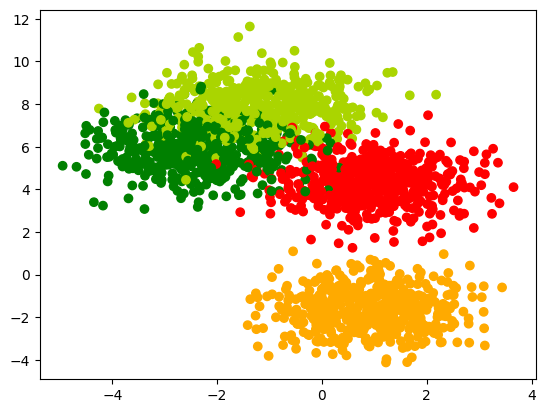

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
data, labels = make_moons(n_samples=300, noise=0.2, random_state=42)
print(data.shape, labels.shape)

(300, 2) (300,)


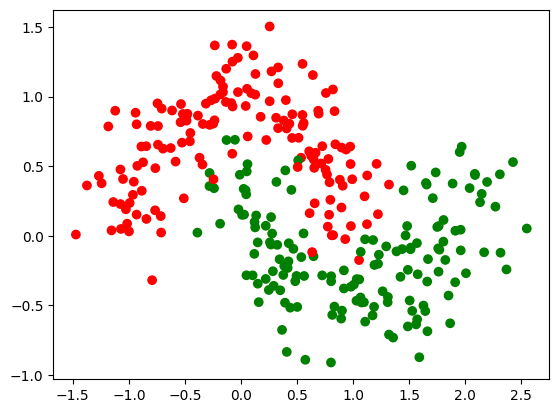

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
X, y = make_circles(random_state=42)

In [ ]:
print(X.shape, y.shape)

(100, 2) (100,)


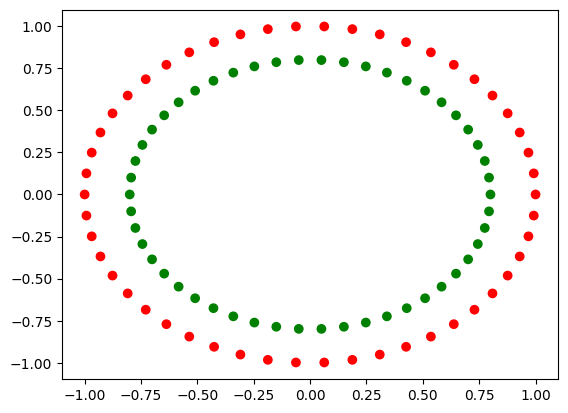

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=my_cmap)
plt.show()


Practical 3:

Design a feedforward neural network from scratch for following neural network.

A) Binary Classification

![image.png](attachment:497c531c-b24c-49c4-8486-9e8fb013d2e5.png)

B)Multiclass Classification(4 input Neuron, 3 neuron in first hidden layer, 4 neuron in second hidden layer,3 neuron in output layer)

![image.png](attachment:44df65e0-7fba-4798-9225-a88db4b9fb6d.png)

Generate dataset using make_blobs,make_moons,make_circles. Use sigmoid activation function for all layer in Binary Classification. Sigmoid at hidden layer and softmax at output layer for multiclass classification. Use mean squared error loss function for binary classification and binary cross entropy loss function for multiclass classification.




Training on blobs dataset:
Epoch 0, Loss: 0.010467963435881385
Epoch 100, Loss: 9.757126006393894e-06
Epoch 200, Loss: 4.8665330590607234e-06
Epoch 300, Loss: 3.2509137898077904e-06
Epoch 400, Loss: 2.436740774687058e-06
Epoch 500, Loss: 1.966617749058006e-06
Epoch 600, Loss: 1.618797932312108e-06
Epoch 700, Loss: 1.3882766653049262e-06
Epoch 800, Loss: 1.2087577862584024e-06
Epoch 900, Loss: 1.0805246298852157e-06


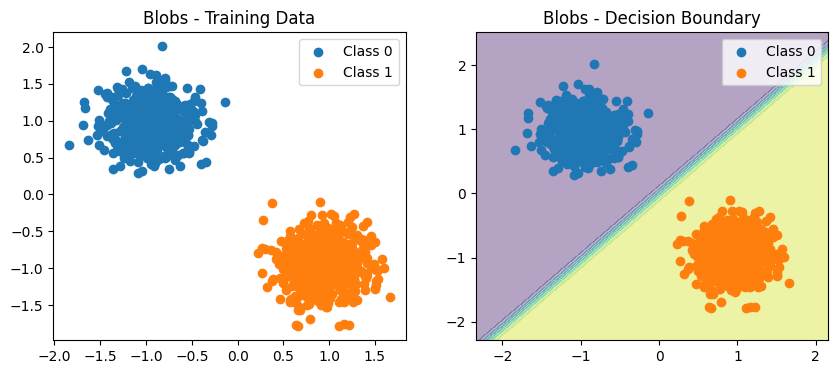


Training on moons dataset:
Epoch 0, Loss: 0.018401315094735284
Epoch 100, Loss: 0.007828794998051251
Epoch 200, Loss: 0.007543298852989127
Epoch 300, Loss: 0.007649338181628594
Epoch 400, Loss: 0.007573708588174951
Epoch 500, Loss: 0.007570143047213302
Epoch 600, Loss: 0.007887302639931901
Epoch 700, Loss: 0.007753419826191582
Epoch 800, Loss: 0.007506928916133506
Epoch 900, Loss: 0.0077364920719424374


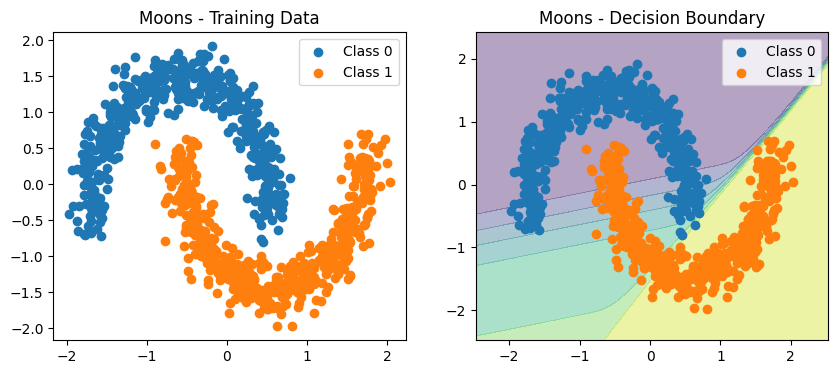


Training on circles dataset:
Epoch 0, Loss: 0.022768748715698
Epoch 100, Loss: 0.021216434482869178
Epoch 200, Loss: 0.021798012487740714
Epoch 300, Loss: 0.021400189600836516
Epoch 400, Loss: 0.021180517628527372
Epoch 500, Loss: 0.021812173510409805
Epoch 600, Loss: 0.02117807039491383
Epoch 700, Loss: 0.021316321874734437
Epoch 800, Loss: 0.020821029091327267
Epoch 900, Loss: 0.02035595384954427


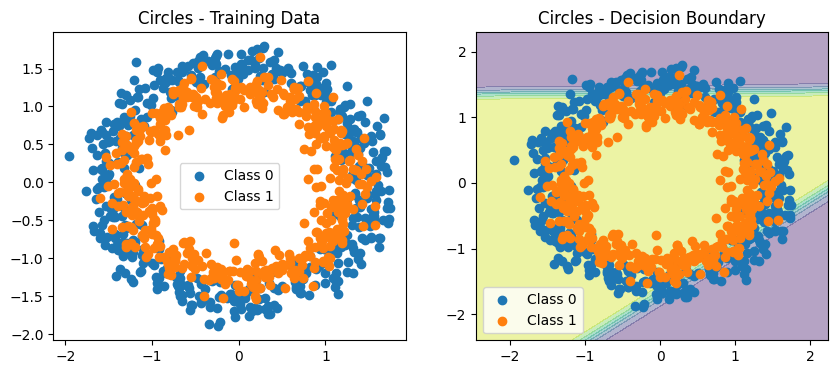

In [ ]:
# Generate datasets and train the network
def generate_and_train():
    # Generate three different datasets
    datasets = {
        'blobs': make_blobs(n_samples=1000, centers=2, n_features=2, random_state=42),
        'moons': make_moons(n_samples=1000, noise=0.1, random_state=42),
        'circles': make_circles(n_samples=1000, noise=0.1, random_state=42)
    }

    for name, (X, y) in datasets.items():
        print(f"\nTraining on {name} dataset:")

        # Normalize the data
        X = (X - X.mean(axis=0)) / X.std(axis=0)

        # Initialize and build the network
        model = FeedForwardNN()
        model.build_network(input_size=2)

        # Train the model
        model.train(X, y.reshape(-1, 1), epochs=1000, learning_rate=0.1, batch_size=32)

        # Plot the results
        plt.figure(figsize=(10, 4))

        # Plot training data
        plt.subplot(121)
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0')
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1')
        plt.title(f'{name.capitalize()} - Training Data')
        plt.legend()

        # Plot decision boundary
        plt.subplot(122)
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0')
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1')
        plt.title(f'{name.capitalize()} - Decision Boundary')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    generate_and_train()